### Black-Litterman model 


The Black-Litterman asset allocation model provides a methodical way of combining an investors subjective views of the future performance of a risky investment asset with the views implied by the market equilibrium. The method has seen wide acceptance amongst practitioners as well as academics.

The Black Litterman procedure can be viewed as a bayesian shrinkage method, that shrinks the expected returns constructed from an investor's views on asset returns towards asset returns implied by the market equilibrium. The procedure computes a set of expected returns that uses the market equilibrium implied  as a prior. This is then combined with returns implied by subjective investor views to produce a set of posterior expected returns $\mu^{BL}$ and covariances $\Sigma^{BL}$.

Besides the obvious attraction of being able to incorporate subjective investor views, the Black-Litterman procedure has a second feature that makes it extremely attractive to portfolio optimization. It is well known that the Markowitz optimization procedure is highly sensitive to estimation errors in Expected Returns and Covariances, and this _error maximizing_ nature of the Markowitz procedure causes unstable portfolios with extreme weights that diverge rapidly from the market equilibrium portfolio even with minor changes to the inputs . 
However, the posterior parameters $\mu^{BL}, \Sigma^{BL}$ computed by the Black Litterman procedure are derived in part from the market portfolio, and therefore are much more pragmatic inputs for purposes of portfolio optimization. Specifically, when $\mu^{BL}, \Sigma^{BL}$ as used as inputs to a Markowitz Optimizer, they produce optimized weights that diverge from the market portfolio in limited ways, and only to the extent of the confidence that the investor expresses in the views. Consequently, the optimized portfolios are more stable portfolios than pure Markowitz optimization with sample estimates. In the extreme, with appropriately set parameters, the Markowitz portfolio computed from the Black-Litterman parameters when there are no subjective investor views exactly coincides and is able to recover the market equilibrium portfolio.

Implied return, proportional prior and posterior expected returns for 60/40 portfolio (10/17/2022) 

### 60/40 Portfolio Example: Prior  

We start with a 2-Asset example.

Consider the portfolio consisting of two ETFs: SPDR S&P 500 ETF Trust (SPY) and iShares 20 Plus Year Treasury Bond ETF (TLT).

SPY has a market capitalization of approximately USD 326B and that of TLT is approximately USD 20B.
Thus, if you held a market-cap weighted portfolio you would hold SPY and TLT with the following weights: $W_{SPY} = 326/346 = 94\%, W_{TLT} = 20/346 = 6\%$. 

We can compute the equilibrium market view of implied returns  $\pi$ as follows:


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

The first step in the Black Litterman procedure was to reverse engineer the implied returns vector $\pi$ from a set of portfolio weights $w$. 

$$\pi = \delta\Sigma w$$

This is performed by the following code:

In [3]:
def implied_returns(delta, sigma, w):
    """
    Obtain the implied expected returns by reverse engineering the weights
    Inputs:
    delta: Risk Aversion Coefficient (scalar)
    sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
    Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() 
    ir.name = 'Implied Returns'
    return ir

# First, we download prices via yfinance and compute returns

port = ['SPY','TLT']
df = yf.download(port, 
                      start='2021-10-17', 
                      end='2022-10-17', 
                      progress=False)
df = pd.DataFrame(df["Adj Close"])
rets = df.pct_change().dropna()

# Second, we compute covariance matrix and calculate implied weights of market

cov = rets.cov()

SPY_MCap = 326
TLT_MCap = 20
SPY_w = SPY_MCap/(SPY_MCap + TLT_MCap)
TLT_w = TLT_MCap/(SPY_MCap + TLT_MCap)

port_mktcap = pd.Series({"SPY":SPY_w,"TLT":TLT_w})

# Third, we compute implied return of the last 252 trading day (SPY and TLT) that market assumes given the MCap   
# Delta = the risk aversion parameter can be set arbitrarily. 
# For instance, some authors use  𝛿=2.5, or it can be historic Sharpe ratio of particular market if we compute IR of stocks in given index.  

ir = pd.DataFrame(implied_returns(delta=2.5, sigma=cov, w=port_mktcap), index=port_mktcap.index).T

# Daily returns are the following:

ir

,SPY,TLT
Implied Returns,0.000478,0.000013


### VOLATILITY estimate - GARCH(1,1)
Now that we computed market views of implied daily return for SPY/TLT portfolio given weights (94% / 6%) next thing is to estimate what are volatilities for given ETFs.

For vol estimate we will use GARCH(1,1):

$\sigma^2_t = ω+α_{1}u^2_{t−1}+β_1σ^2_{t−1}$

In [4]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

[]

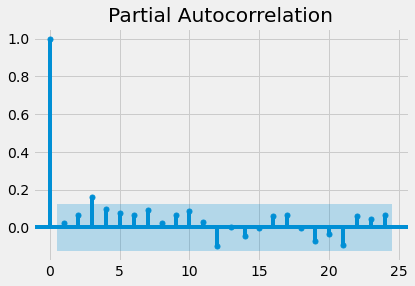

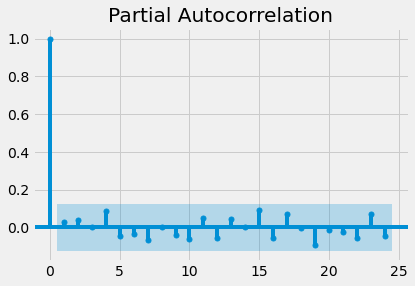

In [5]:
plot_pacf(rets["SPY"]**2)
plot_pacf(rets["TLT"]**2)
plt.plot()

In [6]:
model_SPY = arch_model(rets["SPY"]*100, p=1 ,q=1)
model_fit_SPY = model_SPY.fit()

model_TLT = arch_model(rets["TLT"]*100, p=1 ,q=1)
model_fit_TLT = model_TLT.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 952.8821656725082
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1081.9600266666098
Iteration:      3,   Func. Count:     23,   Neg. LLF: 767.2249423615128
Iteration:      4,   Func. Count:     30,   Neg. LLF: 430.22805820055487
Iteration:      5,   Func. Count:     35,   Neg. LLF: 876.2944526628912
Iteration:      6,   Func. Count:     42,   Neg. LLF: 737.3664747766103
Iteration:      7,   Func. Count:     49,   Neg. LLF: 429.87347049866844
Iteration:      8,   Func. Count:     54,   Neg. LLF: 429.86826992114584
Iteration:      9,   Func. Count:     59,   Neg. LLF: 429.86416246928223
Iteration:     10,   Func. Count:     64,   Neg. LLF: 429.8638110414405
Iteration:     11,   Func. Count:     69,   Neg. LLF: 429.8637437170442
Iteration:     12,   Func. Count:     74,   Neg. LLF: 429.8637386137249
Iteration:     13,   Func. Count:     78,   Neg. LLF: 429.86373861360556
Optimization terminated successfully    (Exit mode 0)
    

In [7]:
model_fit_SPY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -429.864
Distribution:                  Normal   AIC:                           867.727
Method:            Maximum Likelihood   BIC:                           881.813
                                        No. Observations:                  250
Date:                Wed, Oct 19 2022   Df Residuals:                      249
Time:                        14:53:52   Df Model:                            1
                                Mean Model                               
=========================================================================
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -8.2183e-03  9.233e-02 -8.901e-02      0.929 [ -0.189,  0.173]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0279  2.518e-02      1.107      0.268 [-2.148e-02,7.722e-02]
alpha[1]       0.0443      0.117      0.379      0.705      [ -0.185,  0.274]
beta[1]        0.9480      0.119      7.984  1.416e-15      [  0.715,  1.181]
=============================================================================

Covariance estimator: robust
"""

In [8]:
omega_SPY = model_fit_SPY.params['omega']
a_SPY = model_fit_SPY.params['alpha[1]']
b_SPY = model_fit_SPY.params['beta[1]']

GARCH_SPY = (omega_SPY) + (a_SPY*((1+rets["SPY"].mean())**(252)-1)**2) + (b_SPY*(rets["SPY"].std()*(252**0.5))**2)
GARCH_SPY,(GARCH_SPY/(252**0.5))

(0.07769862601420685, 0.00489455337250012)

In [9]:
model_fit_TLT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    TLT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -397.941
Distribution:                  Normal   AIC:                           803.882
Method:            Maximum Likelihood   BIC:                           817.968
                                        No. Observations:                  250
Date:                Wed, Oct 19 2022   Df Residuals:                      249
Time:                        14:53:52   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1303  7.498e-02     -1.738  8.214e-02 [ -0.277,1.661e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.3921e-03  1.616e-02      0.457      0.647 [-2.428e-02,3.907e-02]
alpha[1]       0.0000  1.363e-02      0.000      1.000 [-2.671e-02,2.671e-02]
beta[1]        0.9968  2.167e-02     45.991      0.000      [  0.954,  1.039]
=============================================================================

Covariance estimator: robust
"""

In [10]:
omega_TLT = model_fit_TLT.params['omega']
a_TLT = model_fit_TLT.params['alpha[1]']
b_TLT = model_fit_TLT.params['beta[1]']

GARCH_TLT = (omega_TLT) + (a_TLT*((1+rets["TLT"].mean())**(252)-1)**2) + (b_TLT*(rets["TLT"].std()*(252**0.5))**2)

In [11]:
# To compute daily we have to de-annulaized

garch_d_SPY = GARCH_SPY/(252**0.5)
garch_d_TLT = GARCH_TLT/(252**0.5)

vol_list = [pd.DataFrame({garch_d_SPY}), pd.DataFrame({garch_d_TLT})]
vol_estimate = pd.concat(vol_list, axis=1)
vol_estimate.columns =["SPY","TLT"]
vol_estimate.index = ['Daily Volatility Estimate']
vol_estimate

,SPY,TLT
Daily Volatility Estimate,0.004895,0.002738


# Monte Carlo simulation
Now that we computed daily implied returns (SPY:0.000478, TLT:0.000013) and daily expected volatilities (SPY:0.004895, TLT:0.002738) for the next 252 days, we can use the stochastic model (Monte Carlo) to simulate 10.000 trajectories for the next 252 days for both ETFs.

$Drift = \pi - 1/2σ^2$

$Volatility = σZ[Rand(0;1)]$

$r = (\pi - 1/2σ^2) + σZ[Rand(0;1)]$

$S_t = S_{t-1} * e^{(\pi - 1/2σ^2+σZ[Rand(0;1)])}$




In [13]:
from scipy.stats import norm
x = np.random.rand(10, 2)
Z = norm.ppf(np.random.rand(10,2))

t_intervals = 252
iterations = 10000

S0 = df["SPY"][-1]
S1 = df["TLT"][-1]

u_spy = ir["SPY"]
u_tlt = ir["TLT"]

stdev_spy = garch_d_SPY
stdev_tlt = garch_d_TLT

var_spy = stdev_spy**2
var_tlt = stdev_tlt**2

drift_spy = u_spy - (0.5 * var_spy)
drift_tlt = u_tlt - (0.5 * var_tlt)

daily_returns_spy = np.exp(np.array(drift_spy) + np.array(stdev_spy) * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns_tlt = np.exp(np.array(drift_tlt) + np.array(stdev_tlt) * norm.ppf(np.random.rand(t_intervals, iterations)))

price_list_spy = np.zeros_like(daily_returns_spy)
price_list_tlt = np.zeros_like(daily_returns_tlt)

price_list_spy[0] = S0
price_list_tlt[0] = S1

for t in range(1, t_intervals):
    price_list_spy[t] = price_list_spy[t - 1] * daily_returns_spy[t]
    
for t in range(1, t_intervals):
    price_list_tlt[t] = price_list_tlt[t - 1] * daily_returns_tlt[t]

pl_spy = price_list_spy[251,]
pl_tlt = price_list_tlt[251,]

spy = np.sort(pl_spy)
tlt = np.sort(pl_tlt)

df_describe_spy = pd.DataFrame(spy)
df_describe_tlt = pd.DataFrame(tlt)

stat_spy = df_describe_spy.describe()
stat_tlt = df_describe_tlt.describe()

stat_list = [pd.DataFrame(stat_spy), pd.DataFrame(stat_tlt)]
mc_estimate = pd.concat(stat_list, axis=1)
mc_estimate.columns =["SPY","TLT"]

# Statistics for the last projected day

mc_estimate

,SPY,TLT
count,10000.000000,10000.000000
mean,402.947287,98.818031
std,31.568524,4.321020
min,296.839718,84.415285
25%,380.770715,95.907523
50%,401.574937,98.691996
75%,423.697394,101.658433
max,553.992289,118.846732


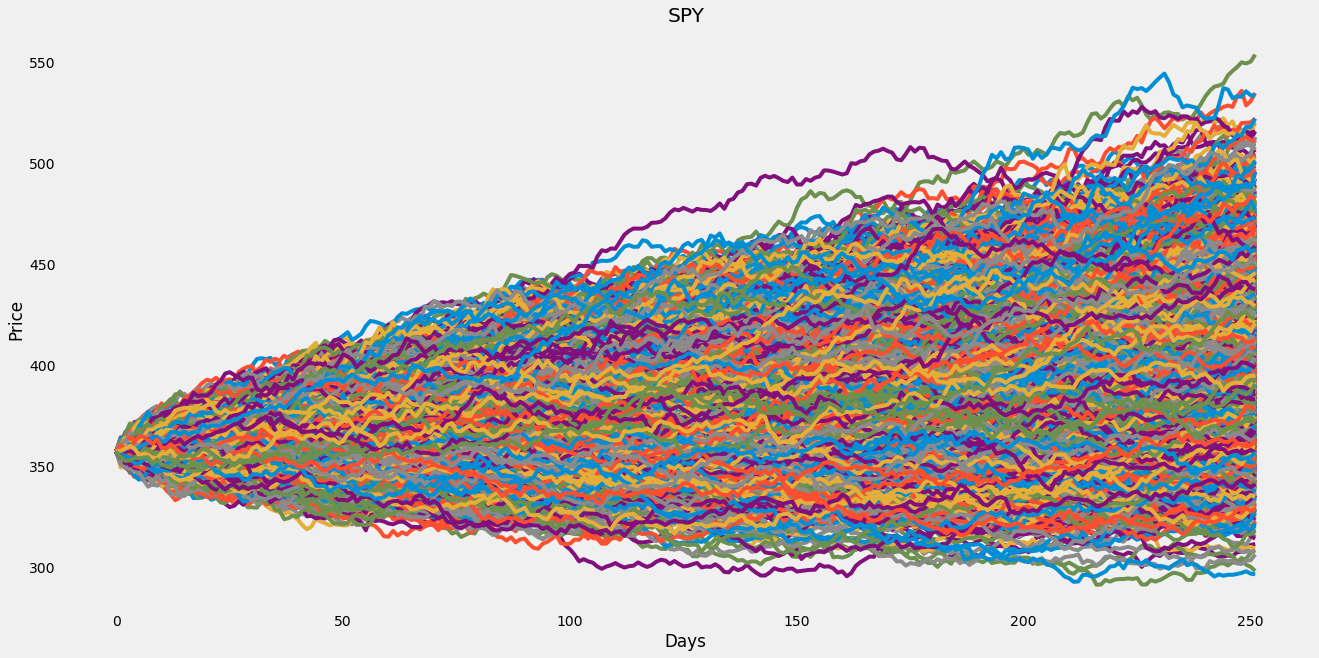

In [15]:
for t in range(1, t_intervals):
    price_list_spy[t] = price_list_spy[t - 1] * daily_returns_spy[t]

plt.figure(figsize=(20,10))
plt.plot(price_list_spy)
plt.title('SPY')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.rcParams['axes.facecolor'] = 'white'

# Subjective view

In [16]:
target_spy =  mc_estimate["SPY"]["50%"]
target_tlt =  mc_estimate["TLT"]["50%"]

exp_ret_spy = (target_spy/df["SPY"][-1]) -1
exp_ret_tlt = (target_tlt/df["TLT"][-1]) -1

er_list = [pd.DataFrame({exp_ret_spy}), pd.DataFrame({exp_ret_tlt})]
expected_r = pd.concat(er_list, axis=1)
expected_r.columns =["SPY","TLT"]
expected_r.index = ['Expected Returns 1Y forward']
expected_r

,SPY,TLT
Expected Returns 1Y forward,0.122878,0.001238


Now we have projected subjective views for both ETFs.

If we use the median for the last projected day as a target price then we project the return: 

SPY= 12.3%
TLT= 0.12%

### 60/40 Portfolio Example: Posterior

We use this function to compute the posterior expected returns as follows:

In [18]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
    # Computes the posterior expected returns based on 
    # the original black litterman reference model
    # W.prior must be an N x 1 vector of weights, a Series
    # Sigma.prior is an N x N covariance matrix, a DataFrame
    # P must be a K x N matrix linking Q and the Assets, a DataFrame
    # Q must be an K x 1 vector of views, a Series
    # Omega must be a K x K matrix a DataFrame, or None
    # if Omega is None, we assume it is
    #    proportional to variance of the prior
    # delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    N = w_prior.shape[0]
    K = q.shape[0]
    pi = implied_returns(delta, sigma_prior,  w_prior)
    sigma_prior_scaled = tau * sigma_prior  
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)


In [19]:
subjective_views = pd.Series({'SPY':0.124854, 'TLT': 0.001653 })
default_port = pd.Series({'SPY': 0.60, 'TLT': 0.40})
sp = cov*252
p = pd.DataFrame([
    {'SPY': 1, 'TLT': 0},
    {'SPY': 0, 'TLT': 1}
    ])
delta = 2.5

bl_mu, bl_sigma = bl(w_prior=default_port,sigma_prior=sp,omega=proportional_prior(sp,1/252, p), p=p, q=subjective_views,  delta=delta,  tau = 1/252)
bl_mu, bl_sigma

(SPY    0.100618
 TLT    0.018082
 dtype: float64,
           SPY       TLT
 SPY  0.051333 -0.000854
 TLT -0.000854  0.036266)

# B-L posterior returns
Finally, we have computed posterior returns that consist of our views* and benchmark (traditional 60/40 portfolio) implied views. 

SPY = 10.06%

TLT =  1.80%

Since we do not have a quantifiable measure for uncertainty  in our views we used $delta$ (The investor's Risk Aversion parameter) = 2.5 and for $tau$ (A scalar indicating the uncertainty of the prior) = 1/projected days (252) as elaborated in literature.

*Our view is a combination of market implied returns for each ETF, volatility estimate (GARCH), and finally M-C simulation with inputs of IR and GARCH 

# Portfolio construction
The last step is to construct weights for the portfolio. 

For this we will use three different methods: 

> $MSR - Max Sharpe Ratio optimization$;

> $GMV - Global Min Var $;

> $EW - Equally Weighted $




In [20]:
from scipy.optimize import minimize

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol

In [21]:
# MSR
# Constrains: - at least 10% on position
#             - weights must be sum to 1


def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.1, 1),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


FFR_futures_30d = 0.038
er = bl_mu
cov = bl_sigma
MSR = pd.DataFrame(msr(FFR_futures_30d, er, cov), index=er.index)
MSR.columns = ["Max Sharpe Ratio"]
MSR

,Max Sharpe Ratio
SPY,0.9
TLT,0.1


In [22]:
# GMV

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

GMV = pd.DataFrame(gmv(bl_sigma), index=bl_sigma.index)
GMV.columns = ["Global Minimum Volatility"]
GMV

,Global Minimum Volatility
SPY,0.415642
TLT,0.584358


In [23]:
# EW

EW = pd.DataFrame(pd.Series({"SPY":0.5,"TLT":0.5}), index=bl_mu.index)
EW.columns = ["Equally Weights"]
EW

,Equally Weights
SPY,0.5
TLT,0.5


# Portfolio Weights

In [25]:
pd.concat([MSR, GMV, EW], axis=1)

,Max Sharpe Ratio,Global Minimum Volatility,Equally Weights
SPY,0.9,0.415642,0.5
TLT,0.1,0.584358,0.5


# Expected Returns of portfolio constituents and given portfolio as well as expected volatilities.

In [26]:
ports = pd.concat([MSR, GMV, EW], axis=1)
er = (ports.T*pd.Series(bl_mu)).T
er_ports = portfolio_return(ports, pd.Series(bl_mu))
er = er.append(er_ports, ignore_index=True)

MSR_vol = portfolio_vol(ports["Max Sharpe Ratio"], bl_sigma)
GMV_vol = portfolio_vol(ports["Global Minimum Volatility"], bl_sigma)
EW_vol =  portfolio_vol(ports["Equally Weights"], bl_sigma)
port_vol_list = pd.DataFrame(pd.Series({"Max Sharpe Ratio":MSR_vol,"Global Minimum Volatility":GMV_vol, "Equally Weights":EW_vol})).T
ev_ports = port_vol_list

er = er.append(ev_ports, ignore_index=True)
er.index = ['SPY_Exp_Rt','TLT_Exp_Rt','Port_Exp_Rt','Port_Exp_Vol']
er

,Max Sharpe Ratio,Global Minimum Volatility,Equally Weights
SPY_Exp_Rt,0.090556,0.041821,0.050309
TLT_Exp_Rt,0.001808,0.010566,0.009041
Port_Exp_Rt,0.092364,0.052387,0.059350
Port_Exp_Vol,0.204424,0.144351,0.146536
